# 1. IMPORTS

## 1.1 Libraries

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup 
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


## 1.2 Raw data

In [5]:
DATA_FOLDER = 'data/'
CHARACTER_METADATA_DATASET = DATA_FOLDER+"character.metadata.tsv"
MOVIE_METADATA_DATASET = DATA_FOLDER+"movie.metadata.tsv"
EVENT_CODE = DATA_FOLDER+"data_events.txt"
PLOT_SUMMARIES = DATA_FOLDER+"plot_summaries.txt"

column_names_character = [
    'Wikipedia movie ID',
    'Freebase movie ID',
    'Movie release date',
    'Character name',
    'Actor date of birth',
    'Actor gender',
    'Actor height (in meters)',
    'Actor ethnicity (Freebase ID)',
    'Actor name',
    'Actor age at movie release',
    'Freebase character/actor map ID',
    'Freebase character ID',
    'Freebase actor ID'
]

column_names_movie = [
    'Wikipedia movie ID',
    'Freebase movie ID',
    'Movie name',
    'Movie release date',
    'Movie box office revenue',
    'Movie runtime',
    'Movie languages',
    'Movie countries',
    'Movie genres'
]
df_character=pd.read_csv(CHARACTER_METADATA_DATASET, sep='\t', names = column_names_character)
df_movie=pd.read_csv(MOVIE_METADATA_DATASET, sep='\t', names = column_names_movie)
with open(EVENT_CODE, encoding='utf-8') as file:
    html_code = file.read()

with open(PLOT_SUMMARIES, 'r', encoding='utf-8') as file:
    plot_summaries = file.readlines()

# 2. Data Selection

In [7]:
# Columns we will use for our project
df = df_movie[['Wikipedia movie ID', 'Movie name', 'Movie release date','Movie box office revenue','Movie runtime','Movie languages','Movie countries','Movie genres']] # and themes to add
df.set_index('Wikipedia movie ID', inplace=True)

df.head(5)

,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,
975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
28463795,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
9363483,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
261236,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [8]:
is_unique = df.index.is_unique
print("Is the index unique?", is_unique)

Is the index unique? True


In [9]:
df.dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81741 entries, 975900 to 12476867
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Movie name                81741 non-null  object 
 1   Movie release date        74839 non-null  object 
 2   Movie box office revenue  8401 non-null   float64
 3   Movie runtime             61291 non-null  float64
 4   Movie languages           81741 non-null  object 
 5   Movie countries           81741 non-null  object 
 6   Movie genres              81741 non-null  object 
dtypes: float64(2), object(5)
memory usage: 7.0+ MB


# 3. Data handling

## 3.1 Prepare dates

In [12]:
#Problem : We don't have the day and month for many movies (+- half) and some don't have a date at all.
#Solution : Create a "year" column and "month" which will be useful for further analysis and column with nan values when it's missing. 
# Extract the first 4 characters, handling NaNs
df_treated = df.copy()
df_treated['Movie release year'] = df_treated['Movie release date'].str[:4].astype('Int32') #7k nans


cols = list(df_treated.columns)
cols.insert(1, cols.pop(cols.index('Movie release year')))
df_treated = df_treated[cols]

df_treated['Movie release date'] = pd.to_datetime(df_treated['Movie release date'], errors='coerce') #42k nans
df_treated['Movie release month'] = df_treated['Movie release date'].dt.strftime('%m').astype('Int32')

print(df_treated['Movie release date'].isna().sum())
print(df_treated['Movie release year'].isna().sum())
print(df_treated['Movie release month'].isna().sum())

cols = list(df_treated.columns)
cols.insert(1, cols.pop(cols.index('Movie release month')))
df_treated = df_treated[cols]
df_treated.head(5) 

42369
6902
42369


,Movie name,Movie release month,Movie release year,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,,
975900,Ghosts of Mars,8,2001,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2,2000,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
28463795,Brun bitter,<NA>,1988,NaT,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
9363483,White Of The Eye,<NA>,1987,NaT,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
261236,A Woman in Flames,<NA>,1983,NaT,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [13]:
df_treated.shape

(81741, 9)

In [14]:
df_treated.dtypes


Movie name                          object
Movie release month                  Int32
Movie release year                   Int32
Movie release date          datetime64[ns]
Movie box office revenue           float64
Movie runtime                      float64
Movie languages                     object
Movie countries                     object
Movie genres                        object
dtype: object

## 3.2 Preprare box office

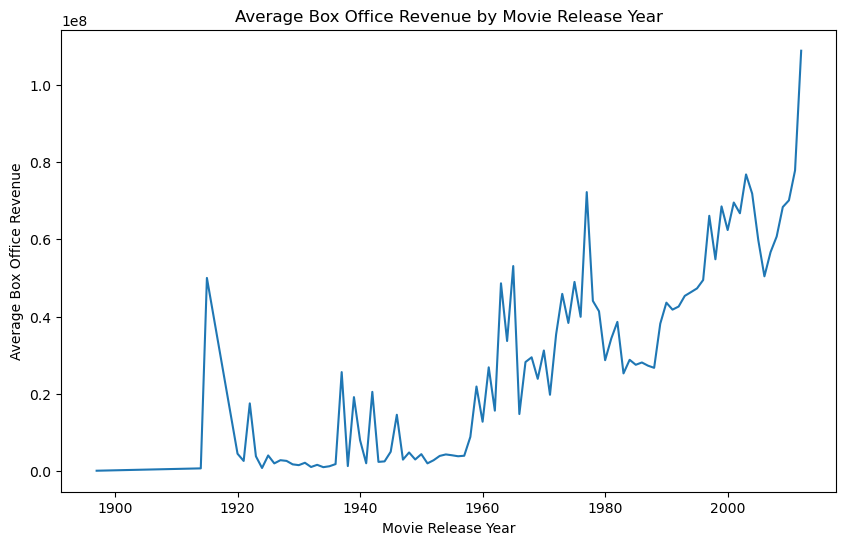

In [16]:
df_plot = df_treated.dropna(subset=['Movie release year', 'Movie box office revenue'])
average_revenue_per_year = df_plot.groupby('Movie release year')['Movie box office revenue'].mean()
plt.figure(figsize=(10, 6))
plt.plot(average_revenue_per_year[1:].index, average_revenue_per_year[1:].values)
plt.xlabel("Movie Release Year")
plt.ylabel("Average Box Office Revenue")
plt.title("Average Box Office Revenue by Movie Release Year")
plt.show()

In [17]:
#Problem : one cannot compare two box office values between each other as there is inflation over time and the box office revenues were measured in different years.
#Solution : adjust the (USD) box office revenue by converting the box office revenue to 2024 with the inflation rates. 
inflation_data = {
    1914: 1.3, 1915: 0.9, 1916: 7.7, 1917: 17.8, 1918: 17.3, 
    1919: 15.2, 1920: 15.6, 1921: -10.9, 1922: -6.2, 1923: 1.8, 
    1924: 0.4, 1925: 2.4, 1926: 0.9, 1927: -1.9, 1928: -1.2, 
    1929: 0.0, 1930: -2.7, 1931: -8.9, 1932: -10.3, 1933: -5.2, 
    1934: 3.5, 1935: 2.6, 1936: 1.0, 1937: 3.7, 1938: -2.0, 
    1939: -1.3, 1940: 0.7, 1941: 5.1, 1942: 10.9, 1943: 6.0, 
    1944: 1.6, 1945: 2.3, 1946: 8.5, 1947: 14.4, 1948: 7.7, 
    1949: -1.0, 1950: 1.1, 1951: 7.9, 1952: 2.3, 1953: 0.8, 
    1954: 0.3, 1955: -0.3, 1956: 1.5, 1957: 3.3, 1958: 2.7, 
    1959: 1.08, 1960: 1.5, 1961: 1.1, 1962: 1.2, 1963: 1.2, 
    1964: 1.3, 1965: 1.6, 1966: 3.0, 1967: 2.8, 1968: 4.3, 
    1969: 5.5, 1970: 5.8, 1971: 4.3, 1972: 3.3, 1973: 6.2, 
    1974: 11.1, 1975: 9.1, 1976: 5.7, 1977: 6.5, 1978: 7.6, 
    1979: 11.3, 1980: 13.5, 1981: 10.3, 1982: 6.1, 1983: 3.2, 
    1984: 4.3, 1985: 3.5, 1986: 1.9, 1987: 3.7, 1988: 4.1, 
    1989: 4.8, 1990: 5.4, 1991: 4.2, 1992: 3.0, 1993: 3.0, 
    1994: 2.6, 1995: 2.8, 1996: 2.9, 1997: 2.3, 1998: 1.6, 
    1999: 2.2, 2000: 3.4, 2001: 2.8, 2002: 1.6, 2003: 2.3, 
    2004: 2.7, 2005: 3.4, 2006: 3.2, 2007: 2.9, 2008: 3.8, 
    2009: -0.4, 2010: 1.6, 2011: 3.2, 2012: 2.1, 2013: 1.5, 
    2014: 1.6, 2015: 0.1, 2016: 1.3, 2017: 2.1, 2018: 2.4, 
    2019: 1.8, 2020: 1.2, 2021: 4.7, 2022: 8.0, 2023: 4.1, 2024: 3.2
}

#source : minesota website

def adjust_for_inflation(year, amount, inflation_data):
    """
    Adjusts the given amount from the provided year to 2024 based on annual inflation rates.

    Parameters:
    year (int): The starting year.
    amount (float): The amount to be adjusted.
    inflation_data (dict): A dictionary with years as keys and inflation rates as values.

    Returns:
    float: The inflation-adjusted amount for 2024.
    """
    adjusted_value = amount
    
    for y in range(year, 2024):
        if y in inflation_data:
            inflation_rate = inflation_data[y]
            # Adjust for inflation for each year
            adjusted_value *= (1 + inflation_rate / 100)
    return adjusted_value


for i in range(len(df_treated)):
    if pd.notna(df_treated.iloc[i]['Movie release year']) and pd.notna(df_treated.iloc[i]['Movie box office revenue']):
        release_year = df_treated['Movie release year'].iloc[i]
        
        adjusted_revenue = adjust_for_inflation(release_year, df_treated.iloc[i]['Movie box office revenue'], inflation_data)
        
        df_treated.iloc[i, df_treated.columns.get_loc('Movie box office revenue')] = adjusted_revenue
 
df_treated.head(5)

,Movie name,Movie release month,Movie release year,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,,
975900,Ghosts of Mars,8,2001,2001-08-24,2.477118e+07,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2,2000,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
28463795,Brun bitter,<NA>,1988,NaT,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
9363483,White Of The Eye,<NA>,1987,NaT,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
261236,A Woman in Flames,<NA>,1983,NaT,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [18]:
df_treated.shape

(81741, 9)

## 3.3 Prepare languages

In [20]:

def cleaner(value):
    # Remove `{` and `}`
    value = re.sub(r'[{}]', '', value)
    
    # Extract values after ':' that are in between double quotes
    matches = re.findall(r'":\s*"([^"]+)"', value)
    
    # List of words to remove from each match
    words_to_remove = [" Language", " language", " languages", " Languages","\\u00e0 "]
    
    # Remove unwanted words from each match
    if matches:
        for word in words_to_remove:
            matches = [match.replace(word, "") for match in matches]
        return ', '.join(matches)
    
    return value

def remove_unicode_escapes(value):
    # Remove any Unicode escape sequences like \uXXXX
    return re.sub(r'\\u[0-9a-fA-F]{4}', '', value)

    
df_treated['Movie languages'] = df_treated['Movie languages'].apply(cleaner)
df_treated['Movie languages'] = df_treated['Movie languages'].apply(remove_unicode_escapes)

df_treated.head(5)



,Movie name,Movie release month,Movie release year,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,,
975900,Ghosts of Mars,8,2001,2001-08-24,2.477118e+07,98.0,English,"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2,2000,2000-02-16,NaN,95.0,English,"{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
28463795,Brun bitter,<NA>,1988,NaT,NaN,83.0,Norwegian,"{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
9363483,White Of The Eye,<NA>,1987,NaT,NaN,110.0,English,"{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
261236,A Woman in Flames,<NA>,1983,NaT,NaN,106.0,German,"{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [21]:
df_treated['Movie languages'] = df_treated['Movie languages'].apply(lambda x: x.split(', '))
df_treated.head(5)

,Movie name,Movie release month,Movie release year,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,,
975900,Ghosts of Mars,8,2001,2001-08-24,2.477118e+07,98.0,[English],"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2,2000,2000-02-16,NaN,95.0,[English],"{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
28463795,Brun bitter,<NA>,1988,NaT,NaN,83.0,[Norwegian],"{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
9363483,White Of The Eye,<NA>,1987,NaT,NaN,110.0,[English],"{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
261236,A Woman in Flames,<NA>,1983,NaT,NaN,106.0,[German],"{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


## 3.4 Prepare genres

In [23]:
df_treated['Movie genres'] = df_treated['Movie genres'].apply(cleaner)

In [24]:
df_treated['Movie genres'] = df_treated['Movie genres'].apply(lambda x: x.split(', '))
df_treated.head(5)

,Movie name,Movie release month,Movie release year,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,,
975900,Ghosts of Mars,8,2001,2001-08-24,2.477118e+07,98.0,[English],"{""/m/09c7w0"": ""United States of America""}","[Thriller, Science Fiction, Horror, Adventure,..."
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2,2000,2000-02-16,NaN,95.0,[English],"{""/m/09c7w0"": ""United States of America""}","[Mystery, Biographical film, Drama, Crime Drama]"
28463795,Brun bitter,<NA>,1988,NaT,NaN,83.0,[Norwegian],"{""/m/05b4w"": ""Norway""}","[Crime Fiction, Drama]"
9363483,White Of The Eye,<NA>,1987,NaT,NaN,110.0,[English],"{""/m/07ssc"": ""United Kingdom""}","[Thriller, Erotic thriller, Psychological thri..."
261236,A Woman in Flames,<NA>,1983,NaT,NaN,106.0,[German],"{""/m/0345h"": ""Germany""}",[Drama]


## 3.5 Prepare countries

In [26]:
df_treated['Movie countries'] = df_treated['Movie countries'].apply(cleaner)


In [27]:
df_treated['Movie countries'] = df_treated['Movie countries'].apply(lambda x: x.split(', '))
df_treated.head(5)

,Movie name,Movie release month,Movie release year,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,,
975900,Ghosts of Mars,8,2001,2001-08-24,2.477118e+07,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2,2000,2000-02-16,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
28463795,Brun bitter,<NA>,1988,NaT,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]"
9363483,White Of The Eye,<NA>,1987,NaT,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
261236,A Woman in Flames,<NA>,1983,NaT,NaN,106.0,[German],[Germany],[Drama]


## 3.6 Remove unrealistic values

In [29]:
df_treated.shape

(81741, 9)

In [30]:
# Get the movie names of the long movies
is_long_movie = df_treated['Movie runtime'] > 10000
long_movies = df_treated.loc[df_treated[is_long_movie].index]
long_movies

,Movie name,Movie release month,Movie release year,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,,
10815585,Zero Tolerance,<NA>,1995,NaT,NaN,1079281.0,[English],[United States of America],"[Thriller, Crime Fiction, Action, Indie, Actio..."
32441022,Modern Times Forever,<NA>,<NA>,NaT,NaN,14400.0,[],[],[Documentary]


In [31]:
# Get the movie names of movies under a second
is_short_movie = df_treated['Movie runtime'] < 0.0166667

short_movies = df_treated.loc[df_treated[is_short_movie].index]
short_movies

,Movie name,Movie release month,Movie release year,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,,
786716,Dickson Experimental Sound Film,<NA>,1894,NaT,NaN,0.0,[English],[United States of America],[Short Film]


In [32]:
highest_runtimes = df_treated['Movie runtime'].nlargest(10)
print("10 highest Movie runtime values:\n", highest_runtimes)

lowest_runtimes = df_treated['Movie runtime'].nsmallest(10)
print("10 lowest Movie runtime values:\n", lowest_runtimes)

lowest_years = df_treated['Movie release year'].nsmallest(10)
print("10 lowest Years values:\n", lowest_years)

10 highest Movie runtime values:
 Wikipedia movie ID
10815585    1079281.00
32441022      14400.00
25345684       9360.00
14545195       5700.00
884435         5220.00
21689271       5100.00
36136594       4875.27
884492         2880.00
1348747        2425.00
6012645        1966.00
Name: Movie runtime, dtype: float64
10 lowest Movie runtime values:
 Wikipedia movie ID
786716      0.000000
1082508     0.030000
644824      0.050000
26044155    0.050000
32175981    0.083333
1090697     0.083333
10126013    0.100000
10624432    0.100000
8965694     0.116667
29632234    0.150000
Name: Movie runtime, dtype: float64
10 lowest Years values:
 Wikipedia movie ID
29666067    1010
1082508     1888
12170539    1889
6431996     1890
22770416    1890
32175981    1891
27773121    1891
644824      1891
9999926     1892
9996498     1892
Name: Movie release year, dtype: Int32


In [33]:
# One film of 18k hours and one of 0sec -> remove them because incorrect data
# Many films of under a minute because they're from 1890-1910

# Define minimum and maximum thresholds for reasonable movie runtimes
min_runtime = 0.01  
max_runtime = 10000 


short_movie_indices = df_treated[df_treated['Movie runtime'] < 0.0166667].index
df_treated = df_treated.drop(index=short_movie_indices)
long_movie_indices = df_treated[df_treated['Movie runtime'] > 10000].index
df_treated = df_treated.drop(index=long_movie_indices)

#one movie during the Middle Ages
indices = df_treated[df_treated['Movie release year'] == 1010].index
df_treated = df_treated.drop(index=indices)


In [34]:
df_treated.shape

(81737, 9)

## 3.7 USA events dataset

In [36]:
#https://www.timetoast.com/timelines/us-history-in-the-20th-century
soup = BeautifulSoup(html_code, 'html.parser')

In [37]:
dates = []
titles = []
descriptions = []

entries = soup.find_all('li', class_='list-timeline__item')

for entry in entries:
    date_div = entry.find('div', class_='timeline-item__date')
    date = date_div.time.get_text(strip=True) if date_div and date_div.time else np.nan
    dates.append(date)
    
    title_tag = entry.find('h1', class_='timeline-item__title')
    title = title_tag.get_text(strip=True) if title_tag else np.nan
    titles.append(title)
    
    body_div = entry.find('div', class_='timeline-item__body')
    body = body_div.get_text(strip=True) if body_div else np.nan
    descriptions.append(body)


In [38]:
df_event = pd.DataFrame({'Date': dates,'Title': titles,'Description': descriptions})
df_event['Date'] = pd.to_datetime(df_event['Date'], format="%b %d, %Y")

In [39]:
df_event.head(10)

,Date,Title,Description
0,1900-03-14,Gold Standard Act passed,Established gold as the only standard for rede...
1,1900-11-06,McKinley reelected president,NaN
2,1901-02-25,Congress passes Platt Amendment,"The Platt Amendment, an amendment to a U.S. ar..."
3,1901-02-25,J.P. Morgan creates United States Steel Corp,"1 of the most powerful bankers of his era, he ..."
4,1901-07-29,American Socialist Party formed,a multi-tendency democratic-socialist politica...
5,1901-09-06,McKinley assassinated; TR becomes president,Pres McKinley is shot at the Pan American Expo...
6,1902-10-03,TR intervenes in anthracite coal strike,The strike of 1900 was the prelude to a larger...
7,1903-01-01,Souls of Black Folk,"W. E. B. Du Bois’s landmark book of essays, So..."
8,1903-11-19,Women's Trade Union League Formed,a U.S. org of both working class & more well-o...
9,1903-12-17,Wright Bros. make 1st successful flight,Orville Wright piloted the first powered airpl...


## 3.8 Sentimental Analysis

In [41]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = analyzer.polarity_scores(text)
    compound_score = score['compound']
    if compound_score >= 0.1:
        sentiment = 'positive'
    elif compound_score <= -0.1:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    return sentiment, compound_score

In [42]:
data = []

for line in plot_summaries:
    parts = line.strip().split('\t', 1) # Split each line by the tab character
    if len(parts) == 2:
        movie_id, summary = parts
        sentiment, compound_score = get_sentiment(summary)
        data.append([movie_id, summary, sentiment, compound_score])

df_sent = pd.DataFrame(data, columns=['ID', 'Summary', 'Sentiment', 'Compound Score'])
df_sent = df_sent.set_index('ID')

df_sent.head(10)

,ID,Summary,Sentiment,Compound Score
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",neutral,0.0083
1,31186339,The nation of Panem consists of a wealthy Capi...,negative,-0.9941
2,20663735,Poovalli Induchoodan is sentenced for six yea...,negative,-0.9867
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",negative,-0.6127
4,595909,Seventh-day Adventist Church pastor Michael Ch...,negative,-0.9538
5,5272176,The president is on his way to give a speech. ...,negative,-0.9946
6,1952976,"{{plot}} The film opens in 1974, as a young gi...",negative,-0.7904
7,24225279,"The story begins with Hannah, a young Jewish t...",negative,-0.5064
8,2462689,Infuriated at being told to write one final co...,negative,-0.9898
9,20532852,A line of people drool at the window of the s...,negative,-0.8176


In [67]:
df_sent.index = df_sent.index.astype('int64')
df_merged = pd.merge(df_treated, df_sent, left_index=True, right_index=True, how='left')


In [53]:
df_event[['Sentiment', 'Compound Score']] = df_event.apply(
    lambda row: pd.Series(get_sentiment(row['Description'])) if pd.notna(row['Description']) else pd.Series(get_sentiment(row['Title'])),
    axis=1)

In [54]:
df_event.head(5)

,Date,Title,Description,Sentiment,Compound Score
0,1900-03-14,Gold Standard Act passed,Established gold as the only standard for rede...,positive,0.8934
1,1900-11-06,McKinley reelected president,NaN,neutral,0.0000
2,1901-02-25,Congress passes Platt Amendment,"The Platt Amendment, an amendment to a U.S. ar...",positive,0.3818
3,1901-02-25,J.P. Morgan creates United States Steel Corp,"1 of the most powerful bankers of his era, he ...",negative,-0.1796
4,1901-07-29,American Socialist Party formed,a multi-tendency democratic-socialist politica...,positive,0.9231


In [69]:
df_merged.sample(5)

,Movie name,Movie release month,Movie release year,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary,Sentiment,Compound Score
Wikipedia movie ID,,,,,,,,,,,,
24463054,Falling Leaves,3,1912,1912-03-15,NaN,12.0,[English],[United States of America],"[Short Film, Drama]",NaN,NaN,NaN
28021622,Bangaru Panjaram,3,1969,1969-03-19,NaN,NaN,[Telugu],[India],[Drama],NaN,NaN,NaN
16885680,Escape from Afghanistan,<NA>,1994,NaT,NaN,86.0,[Russian],[Russia],"[Thriller, Action, War film]",An American reporter and doctor comes to a mi...,negative,-0.5106
12336545,Nujum Pak Belalang,<NA>,1959,NaT,NaN,NaN,[Malay],"[Singapore, Malaysia]","[Musical, Comedy]","The films follows Pak Belalang, a lazy man who...",negative,-0.4215
1685843,Sunny Side of Life,<NA>,1985,NaT,NaN,NaN,[],[],[Documentary],NaN,NaN,NaN


In [70]:
df_merged.shape

(81737, 12)

# 4. Export clean datasets

In [74]:
df_merged.to_csv('generated/cleaned_data.csv', index=True, encoding='utf-8')

In [75]:
df_event.to_csv('generated/usa_historical_events.csv',index = False)